In [2]:
import math
import pyxfoil
import numpy as np
import matplotlib.pyplot as plt
from scipy import integrate

/Users/ndrichmond/VSCode/EAE127/Project 3/pyxfoil.py:170: SyntaxWarning: invalid escape sequence '\.'
  self.name = FindBetween(foil, parent, '\.')


# EAE 127 Project 3 Supplement - Source Panel Method

### Problem 1 and Problem 2 - Functions for the Source Panel Method

&nbsp; &nbsp; &nbsp; &nbsp; In Project 2, we started to work with elementary potential flows and using them to represent complex geometries like airfoils and walls through superposition. Most likely, you found that creating sources one by one and manually adjusting them can end up being a tedious process. In Project 3 we will take a simpler approach and attempt to create these potential flow solutions without manually placing sources and sinks. The easiest way to do this is using a panel method. 

A panel method is a means of aerodynamic analysis where a predefined geometry, like an airfoil is discretized (or split up) into smaller individual components called panels. Each of these panels then has a potential flow element (a source, sink, doublet or a vortex) placed there to satisfy certain boundary conditions. In Project 2, we used the dividing streamline to ensure that no flow would pass our airfoil geometry. In Project 3, we will instead place our sources and sinks along the surface of the airfoil. One complication of the panel method is that once the panels are created, we will also need to develop function to determine the influence of each panel on each other panel in our geometry, this will make a bit more sense as we work through the project. For now, lets take a look at setting up the initial functions we need:

In [3]:
class Panel:
    """
    Here, we are creating a panel object and all its necessary information. 
    """

    def __init__(self, xa, ya, xb, yb):
        """
        Initialization of the panel.

        Here, we write a specific piece of code to be run everytime we create a panel object. In a general sense, the "init" command/function
        will be run every time that we create a new panel.

        Our code needs to calculate the center point of the panel, the length, and its angle.

        Our code also needs to make space for the source strength, tangential velocity, and pressure coefficient
        (which we will define for a specific panel later)
        
        Parameters:
        -----------
        xa: float
            x - coordinate of the first end point
        ya: float
            y - coordinate of the first end point
        xb: float
            x - coordinate of the second end point
        yb: float
            y - coordinate of the second end point
        xc: float
            x - coordinate of the center point of the panel
        yc: float
            y - coordinate of the center point of the panel 
        length: float
            length of the panel
        beta: float
            orientation/angle of the panel

        These parameters are not defined until later. We set them equal to zero below. 
        sigma: float
            source sheet strength
        vt: float
            velocity tangential to the panel
        cp: float
            pressure coefficient


        """

        self.xa, self.ya = xa, ya           # Defines the first end point
        self.xb, self.yb = xb, yb           # Defines the second end point

        # Defining center point and panel parameters
        # You will need to define these yourself:
        self.xc, self.yc = (xa + xb) / 2, (ya + yb) / 2         # Control point or center point (How do you find the center of two points?)
        self.length = math.sqrt((xb - xa)**2 + (yb - ya)**2)    # Length of the panel (How do you find the distance between two points)

        # For the orientation of the panel (angle between x axis and the unit vector normal to the panel)
        if xb - xa <= 0:
            self.beta = math.acos((yb - ya) / self.length)
        elif xb - xa > 0:
            self.beta = math.pi + math.acos(-(yb - ya) / self.length)

        # Location of the panel (we will use this later when we expand our analys to airfoils)
        if self.beta <= math.pi:
            self.loc = 'upper'
        else:
            self.loc = 'lower'

        # Will need a value for theta
        self.theta = math.atan2(self.yc, self.xc)
        # We also need 3 more parameters, sigma, vt for tangential velocity, and cp for pressure distribution. 
        # Create these and set the equal to zero for now
        

        self.sigma = 0.0 
        self.vt = 0.0
        self.cp = 0.0
        



# Objects in Python
> This may be your first time working with an object in python or programming in general. We won't use objects too often in this course but its might be helpful to get an idea of what they are and how they work. An object is somewhat like a more complex version of a variable. While variables usually have one piece of data (or multiple of the same type if they are an array), objects can have multiple different pieces of information in the forms of variables, functions, etc. In the above function, we wrote the code for a panel object, any particular panel instance will now have information/variables that describe its end points, its center points, source strength, etc. 

> If the panel example feels too specific lets use another example. If we wanted, we could create a class of object called Plane. We could then write code such that each Plane object that we create has a specific name, airfoil, chord length, wing span, etc. This saves us time sorting through variables and miscellaneous information. Later on down the line, we could also create specific functions or methods that only work on the Plane object. Our next steps are to create functions like this for our Panel method.

&nbsp; &nbsp; &nbsp; &nbsp;  At this point, we've created the panel object and we can start to use the panels to discretize different geometries. You'll see that in problem 2, we need to discretize a cylinder. Lets quickly try this with a simple implementation. Our first step is to define some geometry, a circle is pretty easily defined using pi. 



In [4]:
N_panels = 6             # We are going to use 6 panels in this quick test to see how our panel function/object works


R = 1.5
x_circle = R * np.cos(np.linspace(0.0, 2 * math.pi, 100))
y_circle = R * np.sin(np.linspace(0.0, 2 * math.pi, 100))

x_points = R * np.cos(np.linspace(0.0, 2 * math.pi, N_panels + 1))
y_points = R * np.sin(np.linspace(0.0, 2 * math.pi, N_panels + 1))
# Here we just create some information that describes a circle, but we will also use these points
# to describe our panel end points. 

cylinder_panels = np.empty(N_panels, dtype = object)     
# The line above creates an array called cylinder_panels, and designates that the type of data we are going to store in this array are objects.
# In other words we will use this array to store all of the panel objects we are about to create. 

# Here is where we will do something new, using our Panel code we created above:
for i in range(N_panels):
    cylinder_panels[i] = Panel(x_points[i], y_points[i], x_points[i+1], y_points[i+1])

> Lets pause for a moment and take a look at the above code. Here, we created some geometry (a circle of radius 1.5), and created an array called cylinder_panels, to hold each of our panel objects. 

> The next set of code begins a for loop that steps through the different points on our circle. Using these points, the Panel function determines where the panels should go for the geometry we've provided. If you take a look at the Panel() code we wrote above, the _init__ command requires self, xa, ya, xb and yb. In the line of code we just wrote we give the function an x coordinate and a y coordinate, followed by a subsequent x coordinate and y coordinate. The Panel() function/class then creates a panel between these two coordinates. The for loop is just for convenience. If we want, we can write a function to simplify this set of code, but lets leave that for later. For now, lets take a look at the results we have when trying to create Panels. 

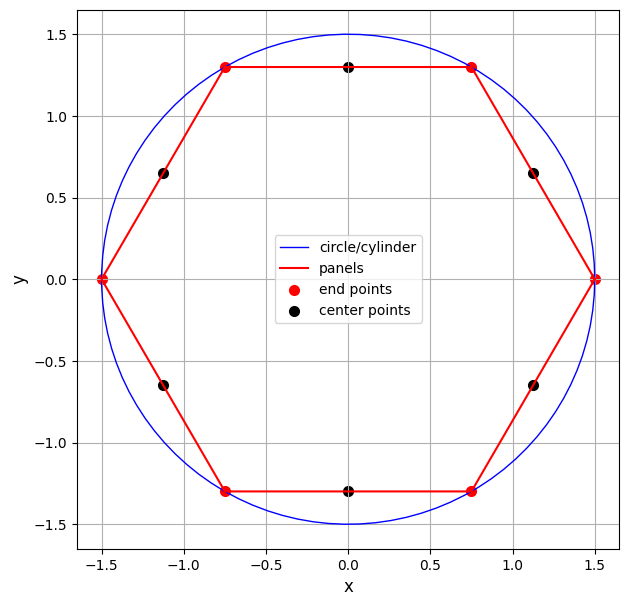

In [5]:
plt.figure(figsize=(7,7))
plt.grid()
plt.xlabel('x', fontsize = 12)
plt.ylabel('y', fontsize = 12)

plt.plot(x_circle, y_circle, label = 'circle/cylinder', color = 'b', linewidth = 1)
# Plotting our circle/the geometry we would like to discretize

plt.plot(x_points, y_points, label = 'panels', color = 'r')
# Plotting our end points / panels
# Here, we are plotting the exact same points that we provided to our Panel function. 
# Remember that we are using these as the end points of our panels

plt.scatter([p.xa for p in cylinder_panels], [p.ya for p in cylinder_panels], label = 'end points', color = 'r', linewidth = 2)
# This code may look a little bit odd to you. The code within the brackets accesses the information 
# inside of the variable 'cylinder_panels'. For each panel inside of 'cylinder_panels', we plot 
# the xa and ya variables associated with those panels.

plt.scatter([p.xc for p in cylinder_panels], [p.yc for p in cylinder_panels], label = 'center points', color = 'k', linewidth = 2)
# The same is done here as above, except we use the center points instead of the end points.
# Using the code here we can access any of the information within a specific Panel object. 

plt.legend(loc = 'best')
plt.show()


&nbsp; &nbsp; &nbsp; &nbsp; As you can see above, we've taken a circular geometry (in blue) and discretized it into 6 individual panels. You will do this with a few more steps in Problem 2. Do you think what we have will be a good approximation? Why or why not? It may not be clear to you yet but we will see that using more panels will lead to a better approximation of aerodynamic behavior. 


### Flow Normal and Tangent to a Panel
Thus far, for our desired geometry, we have only defined the geometry of our panels, but we still need to take a few steps to define the aerodynamic information for each panel. Lets discuss some of the boundary conditions for our panels to help with this. Our first boundary condition is the flow tangency boundary condition. This boundary condition guarantees (or forces) the flow at the surface of the panel to be tangent to the orientation of the panel. We will use the control points or center points to enforce this. So for each panel i in our analysis, we make $u_{n} = 0$ at $(x_{c} , y_{c})$ (the coordinates of the control point). The normal velocity $u_{n}$ is equal to the derivative of the velocity potential. In other words:

$$u_{n_{i}} = \frac{\partial}{\partial n_{i}} \left \{  \phi (x_{c} , y_{c}) \right \} = 0$$

This leads us to the following relationship for all panels:

$$ 0 = U_{\infty}cos(\beta_{i}) +  \sum_{j=1}^{N_{p}} \frac{\sigma_{j}}{2\pi} \int  \frac{(x_{c_{i}} - x_{j}(s_{j})) \frac{\partial_{x_{c_{i}}}}{\partial_{n_{i}}}  + (y_{c_{i}} - y_{j}(s_{j})) \frac{\partial_{y_{c_{i}}}}{\partial_{n_{i}}}    }{(x_{c_{i}} - x_{j}(s))^2 + (y_{c_{i}} - y_{j}(s)) ^2} \,ds_{j}  $$

Remember that we defined $\beta$ as the angle that the panel normal makes with the x axis, and this describes the orientation of the panel. The variable s is a new variable we are using to describe the distance along the length of the panel. So far we have a pretty scary looking equation, lets see if we can make it worse:

$$\frac{\partial x_{c_{i}}}{\partial n_{i}} = cos(\beta_{i})$$ 

$$\frac{\partial y_{c_{i}}}{\partial n_{i}} = sin(\beta_{i})$$

and

$$x_{j}(s_{j}) = x_{a_{j}} - sin(\beta_{j})s_{j}$$ 

$$y_{j}(s_{j}) = y_{a_{j}} + cos(\beta_{j})s_{j}$$ 

This brings us to the final equation for our flow tangency boundary condition:

$$ 0 = U_{\infty}cos(\Beta_{i}) + \frac{\sigma_{i}}{2} + \sum_{j=1 , j \neq i }^{N_{p}} \frac{\sigma_{j}}{2\pi} \int  \frac{(x_{c_{i}} - x_{j}(s_{j}))cos\beta_{i}  + (y_{c_{i}} - y_{j}(s_{j}))sin\beta_{i} } {(x_{c_{i}} - x_{j}(s))^2 + (y_{c_{i}} - y_{j}(s)) ^2} \,ds_{j}  $$

It's okay if we don't understand all the steps from the above equation/derivation. What you should try to take away from the above equation is that the panel method analysis involves evaluating a set of panels. Part of that analysis is evaluating how each panel is affected by the others in the set. The first two terms of the above equation are used to describe a panels influence/effect on itself, while the last term is the effect of every other panel (hence the summation). Now lets take a look at writing the code for the flow tangency boundary condition. We don't need to code the entire equation, but we do need to write the last term which determines the contribution from every other panel. For this we will need a new function from scipy called integrate(). 

In [6]:
def integral_normal(p_i, p_j):
    """
    Evaluates the contribution of a panel at the center-point of another,
    in the normal direction.

    Parameters:
    -----------
    p_i: Panel object
        Panel on which the contribution is calculated.
    p_j: Panel object
        Panel from which the contribution is calculated. 
    """

    def integrand(s):
        return (((p_i.xc - (p_j.xa - math.sin(p_j.beta) * s)) * math.cos(p_i.beta) +
                 (p_i.yc - (p_j.ya + math.cos(p_j.beta) * s)) * math.sin(p_i.beta)) /
                ((p_i.xc - (p_j.xa - math.sin(p_j.beta) * s))**2 +
                 (p_i.yc - (p_j.ya + math.cos(p_j.beta) * s))**2))
    return integrate.quad(integrand, 0.0, p_j.length)[0]

&nbsp; &nbsp; &nbsp; &nbsp; Here, we've written the code to describe the integrand terms in the normal velocity equation. Later on, we will set these terms equal to 0 to enforce the flow tangency condition. Now that we've written out the normal velocity equation, lets take a look at the tangential velocity equation. Here, we don't have a specific requirement for the panel tangent velocity, instead we can just compute the velocity without a restriction. Lets walk through these equations the same way we did for the normal velocity. First we hae the definition of the tangential component of the velocity at every panel i: 

$$u_{t_{i}} = \frac{\partial}{\partial t_{i}} \left \{  \phi (x_{c} , y_{c}) \right \}$$

This equation becomes the following:

$$ u_{t_{i}} = -U_{\infty}sin(\beta_{i}) +  \sum_{j=1 , j \neq i}^{N_{p}} \frac{\sigma_{j}}{2\pi} \int  \frac{(x_{c_{i}} - x_{j}(s_{j})) \frac{\partial_{x_{c_{i}}}}{\partial_{t_{i}}}  + (y_{c_{i}} - y_{j}(s_{j})) \frac{\partial_{y_{c_{i}}}}{\partial_{t_{i}}}    }{(x_{c_{i}} - x_{j}(s))^2 + (y_{c_{i}} - y_{j}(s)) ^2} \,ds_{j}  $$

This should look pretty similar to the normal velocity equation. You should note two things: the partial derivates are taken with respect to the tangent direction, rather than the normal direction, and that the contribution from a panel to itself is 0 (There is no $\frac{\sigma_{i}}{2}$ in the above equation). Our partial derivatives are as follows:


$$\frac{\partial x_{c_{i}}}{\partial t_{i}} = -sin(\beta_{i})$$ 

$$\frac{\partial y_{c_{i}}}{\partial t_{i}} = cos(\beta_{i})$$

We can also reuse the following relation in order to rewrite the tangential velocity equation. 
$$x_{j}(s_{j}) = x_{a_{j}} - sin(\beta_{j})s_{j}$$ 

$$y_{j}(s_{j}) = y_{a_{j}} + cos(\beta_{j})s_{j}$$ 

> The next step is to rewrite the tangential velocity equation and create the code for integral_tangential(). This function will have a similar form as integral_normal()


In [7]:
def integral_tangential(p_i, p_j):
    """
    Evaluates the contribution of a panel at the center-point of another,
    in the tangential direction.
    
    Parameters
    ----------
    p_i: Panel object
        Panel on which the contribution is calculated.
    p_j: Panel object
        Panel from which the contribution is calculated.
    
    Returns
    -------
    Integral over the panel at the center point of the other.
    """

    # You will need to write in the tangetial velocity equation below. 
    # Remember that we only need the terms within the integrand, and we can leave
    # the freestream velocity (U infinity) term for later.
    def integrand(s):
        return ((-(p_i.xc - (p_j.xa - math.sin(p_j.beta) * s)) * math.sin(p_i.beta) +
                 (p_i.yc - (p_j.ya + math.cos(p_j.beta) * s)) * math.cos(p_i.beta)) /
                ((p_i.xc - (p_j.xa - math.sin(p_j.beta) * s))**2 +
                 (p_i.yc - (p_j.ya + math.cos(p_j.beta) * s))**2))
    return integrate.quad(integrand, 0.0, p_j.length)[0]

&nbsp; &nbsp; &nbsp; &nbsp; At this point, we can start using the above functions to describe the important information about our panel system. Our first step is to calculate the strength of sources located at the center of each panel. This is given by the value sigma. Lets revisit the two equations for normal and tangent flow and see where we use sigma. 

Normal: $$ u_{n_{i}} = U_{\infty}cos(\beta_{i}) + \frac{\sigma_{i}}{2} + \sum_{j=1 , j \neq i }^{N_{p}} \frac{\sigma_{j}}{2\pi} \int  \frac{(x_{c_{i}} - x_{j}(s_{j}))cos\beta_{i}  + (y_{c_{i}} - y_{j}(s_{j}))sin\beta_{i} } {(x_{c_{i}} - x_{j}(s))^2 + (y_{c_{i}} - y_{j}(s)) ^2} \,ds_{j}  $$

Tangential: $$ u_{t_{i}} = -U_{\infty}sin(\beta_{i}) + \sum_{j=1 , j \neq i }^{N_{p}} \frac{\sigma_{j}}{2\pi} \int  \frac{(x_{c_{i}} - x_{j}(s_{j}))(-sin\beta_{i})  + (y_{c_{i}} - y_{j}(s_{j}))cos\beta_{i} } {(x_{c_{i}} - x_{j}(s))^2 + (y_{c_{i}} - y_{j}(s)) ^2} \,ds_{j}  $$

We know that for the Normal velocity, the equation needs to be equal to zero at every control point. Lets rearrange the normal equation slightly:
$$ 0= U_{\infty}cos(\beta_{i}) + \frac{\sigma_{i}}{2} + \sum_{j=1 , j \neq i }^{N_{p}} \frac{\sigma_{j}}{2\pi} \int  \frac{(x_{c_{i}} - x_{j}(s_{j}))cos\beta_{i}  + (y_{c_{i}} - y_{j}(s_{j}))sin\beta_{i} } {(x_{c_{i}} - x_{j}(s))^2 + (y_{c_{i}} - y_{j}(s)) ^2} \,ds_{j}  $$

$$ -U_{\infty}cos(\beta_{i}) =   \frac{\sigma_{i}}{2} + \sum_{j=1 , j \neq i }^{N_{p}} \frac{\sigma_{j}}{2\pi} \int  \frac{(x_{c_{i}} - x_{j}(s_{j}))cos\beta_{i}  + (y_{c_{i}} - y_{j}(s_{j}))sin\beta_{i} } {(x_{c_{i}} - x_{j}(s))^2 + (y_{c_{i}} - y_{j}(s)) ^2} \,ds_{j}  $$

If we put all the terms containing sigma on one side, and all the terms without sigma on one side we can set up a system of equations. We are looking to solve for sigma so we can create a system of the form:
$$[A][\sigma] = [b]$$

In this case [b] is equal to $-U_{\infty}cos(\beta_{i})$, while [A] is a matrix containing all the terms from our relevant panels. Lets say we have a panel system with 10 panels, A is a 10 by 10 matrix containing the $\sigma_{i}$ and $\sigma_{j}$ coefficients. Lets try to visualize this:

Since we have A and b, we can solve a system of equations to arrive at the value of $\sigma$ for each of our panels. Lets take a look at how to do this, we can write a new function for analysis of any set of panels. 



In [8]:
def analyze_panels(panels, u_inf):
    """"
    Here, we write some code to analyze our panels after they have been created. 

    Creates a source influence matrix [A]


    Input: an array of panels created using the Panel function (panels) and a freestream velocity (u_inf). 

    """

    Num = len(panels)

    A_n = np.empty((Num, Num), dtype = float)
    np.fill_diagonal(A_n, 0.5)
        # Whenever we have i = j, we have sigma(i)/2 or sigma(i)*0.5. Thus, on our diagonal for matrix A we should have 0.5 
        # The diagonal of a matrix means i = j i.e (1,1), (2,2), etc etc.

    # Create the source influence matrix [A] of the linear system
    for i, p_i in enumerate(panels):
        for j, p_j in enumerate(panels):
            if i != j:
                A_n[i,j] = (0.5/math.pi) * integral_normal(p_i, p_j)

    # Create the right hand side [b] of the linear system
    b_n = - u_inf * np.cos([p.beta for p in panels])

    sigma = np.linalg(A_n,b_n)

    for i, panel in enumerate(panels):
        panel.sigma = sigma[i]



&nbsp; &nbsp; &nbsp; &nbsp; The above code can be run on any set of panels or a panel array to define the source strength at every panel. Unfortunately, this code doesn't calculate the tangential velocity or the pressure distribution for each panel. These are the most useful pieces of information in our panel analysis. Now that we have sigma, we can work toward obtaining those values. Let's edit the above function to calculate the tangential velocity and the pressure distribution.

First lets quickly revisit our tangential velocity equation:

$$ u_{t_{i}} = -U_{\infty}sin(\beta_{i}) +  \sum_{j=1 , j \neq i}^{N_{p}} \frac{\sigma_{j}}{2\pi} \int  \frac{(x_{c_{i}} - x_{j}(s_{j})) \frac{\partial_{x_{c_{i}}}}{\partial_{t_{i}}}  + (y_{c_{i}} - y_{j}(s_{j})) \frac{\partial_{y_{c_{i}}}}{\partial_{t_{i}}}    }{(x_{c_{i}} - x_{j}(s))^2 + (y_{c_{i}} - y_{j}(s)) ^2} \,ds_{j}  $$

We can approach this similarly to our normal velocity equation. Let's treat this as a system of equations that takes the following form:
$$[u_{t}] = [A][\sigma] + [b]$$

&nbsp; &nbsp; &nbsp; &nbsp; We solved for sigma using the flow tangency boundary condition (normal velocity = 0), and now we can use sigma (panel source strength) to calculate the tangential velocity. Our code should look pretty similar to our normal panel analysis. Lets modify our analyze_panels() function to solve for tangential velocity, and the surface pressure coefficient $C_{p}$ at every panel. The formula for surface pressure on some panel i is provided here:

$$C_{p_{i}} = 1 - (\frac{u_{t_{i}}}{U_{\infty}})^2$$

> You should edit the analyze_panels() function to create the source influence matrix [A], the variable [b] and then solve for $u_{t}$ and $C_{p}$

In [9]:
def analyze_panels(panels, u_inf):
    """"
    Here, we write some code to analyze our panels after they have been created. 

    Creates a source influence matrix [A]


    Input: an array of panels created using the Panel function (panels) and a freestream velocity (u_inf). 

    """

    Num = len(panels)

    # First we need the Normal Velocity Calculations

    A_n = np.empty((Num, Num), dtype = float)
    np.fill_diagonal(A_n, 0.5)
        # Whenever we have i = j, we have sigma(i)/2 or sigma(i)*0.5. Thus, on our diagonal for matrix A we should have 0.5 
        # The diagonal of a matrix means i = j i.e (1,1), (2,2), etc etc.

    # Create the source influence matrix [A] of the linear system
    for i, p_i in enumerate(panels):
        for j, p_j in enumerate(panels):
            if i != j:
                A_n[i,j] = (0.5/math.pi) * integral_normal(p_i, p_j)

    # Create the right hand side [b] of the linear system
    b_n = - u_inf * np.cos([p.beta for p in panels])

    sigma = np.linalg.solve(A_n,b_n)

    for i, panel in enumerate(panels):
        panel.sigma = sigma[i]

    # ====================================================================== #
    # Now we need the Tangential Velocity Calculations
    A_t = np.empty((Num, Num), dtype = float)
    np.fill_diagonal(A_t, 0.0)

    # Create the source influence matrix [A] of the linear system
    # STUDENTS WILL FILL THIS IN DELETE LATER
    for i, p_i in enumerate(panels):
        for j, p_j in enumerate(panels):
            if i!=j:
                A_t[i,j] = (0.5 / math.pi) * integral_tangential(p_i, p_j)

    # Create the right hand side [b] of the linear system
    # STUDENTS ALSO FILL THIS IN
    b_t = -u_inf * np.sin([p.beta for p in panels])

    # Finally, we compute the tangential velocity:
    # STUDENTS ALSO FILL THIS IN
    vt = np.dot(A_t, sigma) + b_t

    for i, panel in enumerate(panels):
        panel.vt = vt[i]
    
    # STUDENTS FILL THIS IN
    # Finally, lets use our tangential velocity to calculate surface pressure Cp:
    for panel in panels:
        panel.cp = 1.0 - (panel.vt/u_inf)**2

    print('Panel Analysis Complete!')



&nbsp; &nbsp; &nbsp; &nbsp; At this point our code should be ready to use.  We have a Panel() function that creates a set of panels, and we have analyze_panels(), which calculates the important information associated with every panel. If we return to the first example with a cylinder, we can finish analyzing the set of panels. 

Lets begin by re-plotting our results. 

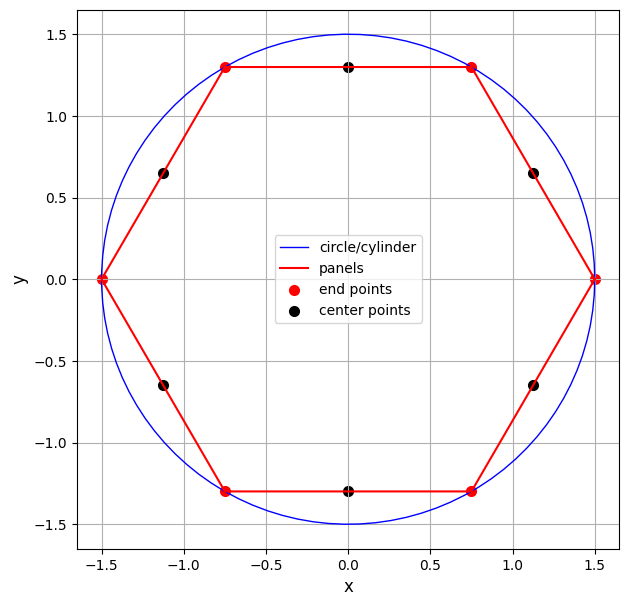

In [10]:
plt.figure(figsize=(7,7))
plt.grid()
plt.xlabel('x', fontsize = 12)
plt.ylabel('y', fontsize = 12)

plt.plot(x_circle, y_circle, label = 'circle/cylinder', color = 'b', linewidth = 1)
# Plotting our circle/the geometry we would like to discretize

plt.plot(x_points, y_points, label = 'panels', color = 'r')
# Plotting our end points / panels

plt.scatter([p.xa for p in cylinder_panels], [p.ya for p in cylinder_panels], label = 'end points', color = 'r', linewidth = 2)
# This code may look a little bit odd to you. The code within the brackets accesses the information 
# inside of the variable 'cylinder_panels'. For each panel inside of 'cylinder_panels', we plot 
# the xa and ya variables associated with those panels.

plt.scatter([p.xc for p in cylinder_panels], [p.yc for p in cylinder_panels], label = 'center points', color = 'k', linewidth = 2)
# The same is done here as above, except we use the center points instead of the end points.
# Using the code here we can access any of the information within a specific Panel object. 

plt.legend(loc = 'best')
plt.show()

&nbsp; &nbsp; &nbsp; &nbsp; Remember that we stored the panels for this example in an array called "cylinder_panels", lets input this array, and a value for freestream velocity into our analyze_panels() function. 

In [11]:
U_infty = 1.0

analyze_panels(cylinder_panels, U_infty)

Panel Analysis Complete!


Our panel analysis should (ideally) complete without any snags. At this point, we have defined the source strength, tangential velocity and pressure coefficient for each panel. Lets take a look at these results for the above example. 

We should also take a look at the analytical solution for the surface pressure coefficient on a cylinder. This is the solution that we should expect when evaluating the surface pressure around a cylinder in cross flow. Its given in the code below (make sure to include it in your subsequent exercises). 


[ 1.5         1.49698001  1.48793222  1.47289305  1.45192305  1.42510668
  1.3925519   1.35438981  1.31077407  1.2618803   1.20790539  1.14906666
  1.08560106  1.01776412  0.945829    0.87008536  0.7908382   0.70840661
  0.62312252  0.53532933  0.44538056  0.3536384   0.26047227  0.1662573
  0.07137287 -0.02379895 -0.11887494 -0.21347226 -0.30721    -0.39971072
 -0.49060194 -0.57951769 -0.66609992 -0.75       -0.8308801  -0.90841453
 -0.9822911  -1.05221233 -1.11789667 -1.17907964 -1.23551487 -1.28697512
 -1.33325317 -1.37416269 -1.40953893 -1.43923946 -1.46314468 -1.48115833
 -1.49320788 -1.49924481 -1.49924481 -1.49320788 -1.48115833 -1.46314468
 -1.43923946 -1.40953893 -1.37416269 -1.33325317 -1.28697512 -1.23551487
 -1.17907964 -1.11789667 -1.05221233 -0.9822911  -0.90841453 -0.8308801
 -0.75       -0.66609992 -0.57951769 -0.49060194 -0.39971072 -0.30721
 -0.21347226 -0.11887494 -0.02379895  0.07137287  0.1662573   0.26047227
  0.3536384   0.44538056  0.53532933  0.62312252  0.7084

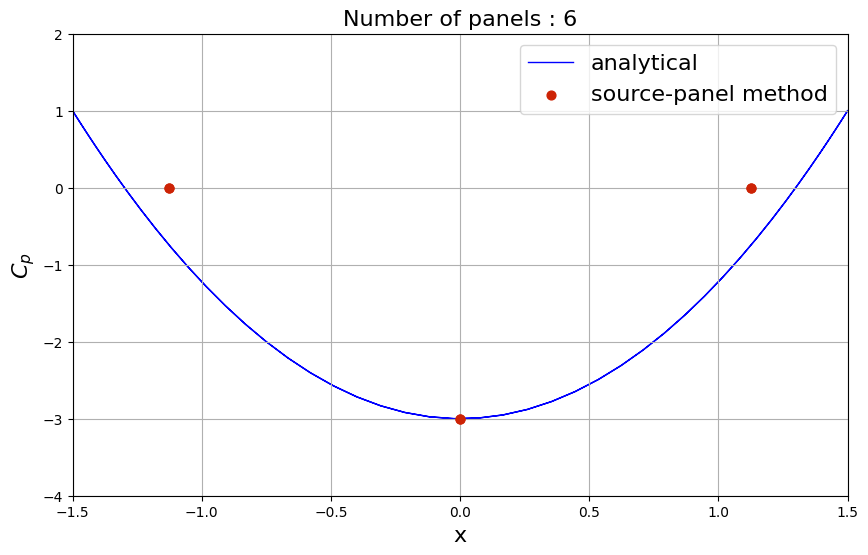

In [12]:
cp_analytical = 1.0 - 4 * (y_circle / R)**2


#print([p.xc for p in cylinder_panels])
#print([p.cp for p in cylinder_panels])

# plot the surface pressure coefficient
plt.figure(figsize=(10, 6))
plt.grid()
plt.xlabel('x', fontsize=16)
plt.ylabel('$C_p$', fontsize=16)

plt.plot(x_circle, cp_analytical,
            label='analytical',
            color='b', linestyle='-', linewidth=1, zorder=1)

plt.scatter([p.xc for p in cylinder_panels], [p.cp for p in cylinder_panels],
               label='source-panel method',
               color='#CD2305', s=40, zorder=2)

plt.title('Number of panels : %d' % N_panels, fontsize=16)
plt.legend(loc='best', prop={'size':16})
plt.xlim(-1.5, 1.5)
plt.ylim(-4.0, 2.0)

print(x_circle)
print(y_circle)

The results above are not necessarily wrong, but in our example, we crated a discretization with 6 panels. The above plot only shows 3 data points for our source panel method. We'll need to adjust our data in order to see all of the data points. The reason the above plot does not completely show our results, is because we've plotted Cp against x. On the surface of our circle, the there are two points that correspond to any value of x, one that has a positive y coordinate and one that has a negative coordinate. A better means to represent our data would be to plot data in terms of theta. In order to do this we'll need to recast our x variable to be in terms of theta. 

100


(-4.0, 2.0)

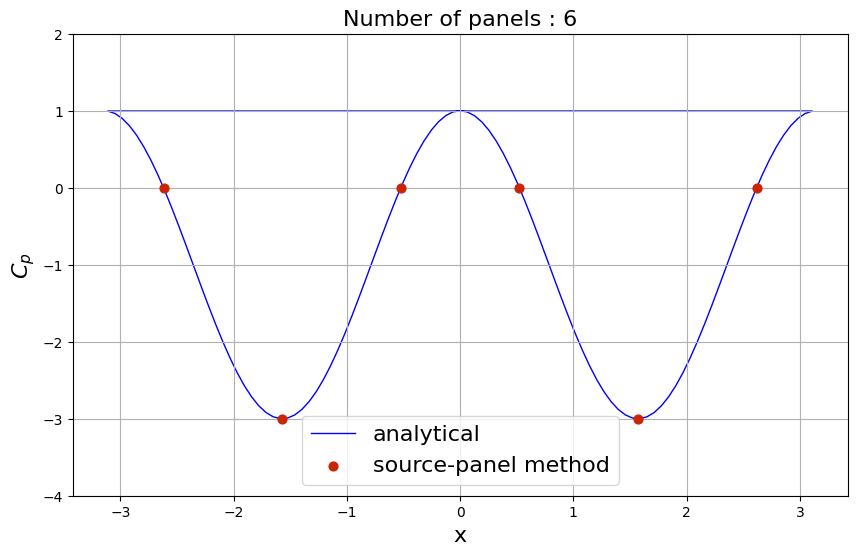

In [13]:

length = (len(x_circle))
theta = np.zeros((length, 1))

for i in range(0, length):
    theta[i] = math.atan2(y_circle[i], x_circle[i])

# print(theta)

cp_analytical = 1.0 - 4 * (y_circle / R)**2

print(len(theta))

# plot the surface pressure coefficient
plt.figure(figsize=(10, 6))
plt.grid()
plt.xlabel('x', fontsize=16)
plt.ylabel('$C_p$', fontsize=16)

plt.plot(theta, cp_analytical,
            label='analytical',
            color='b', linestyle='-', linewidth=1, zorder=1)

plt.scatter([p.theta for p in cylinder_panels], [p.cp for p in cylinder_panels],
               label='source-panel method',
               color='#CD2305', s=40, zorder=2)

plt.title('Number of panels : %d' % N_panels, fontsize=16)
plt.legend(loc='best', prop={'size':16})

plt.ylim(-4.0, 2.0)

&nbsp; &nbsp; &nbsp; &nbsp;  On your own, you should repeat this analysis for different numbers of panels and see if your results improve in accuracy. Now that we've written the necessary functions for our panel analysis, lets revisit the steps we took to arrive at the final results. 

&nbsp; &nbsp; &nbsp; &nbsp; 1.) Define the geometry of your panels  (we did this using x_points and y_points at the beginning of this supplement). 

&nbsp; &nbsp; &nbsp; &nbsp; 2.) Create an array of panels using the Panel() function. This creates the panel objects and describes all the relevant *geometry* information.

&nbsp; &nbsp; &nbsp; &nbsp; 3.) Run analyze_panels() on the set of panels we created. This calculates the *aerodynamic* information for each panel. 

Once you have completed the 4 relevant functions ( Panel(), integral_normal(), integral_tangential(), and analyze_panels()), this will complete Problem 1. For your report for Problem 1 , you should generally discuss how you created these functions and what they do. For Problem 2, you need to repeat the analysis above for the 3 different numbers of panels described in the problem statement (10 panels, 40 panels and 160 panels), and then calculate and plot the error of each number of panels. 
### Problem 3 - Symmetric Airfoil Panel Analysis

&nbsp; &nbsp; &nbsp; &nbsp; For Problem 3 we would like to expand our analysis to include airfoils. Step 1 and Step 2 involves defining a specific geoemtry and set of points to use for each of our panels. This action was somewhat straightforward for a circular geometry, but we want to avoid manually defining panels and their locations with a more complex geometry like an airfoil. Lets take a look at the circular mapping method. In order to complete problem 3, run an inviscid x foil simulation (Re = 0), a viscous simulation, and the source panel method we've developed in this project. Run these simulaation on both a symmetric and cambered airfoil at an angle of attack of 0 degrees.  

Circular mapping uses the geometry of a circle to define the coordinates of panels. 

0
0
1
0
2
1
3
3
4
4
5
7
6
9
7
12
8
15
9
18
10
21
11
25
12
29
13
33
14
36
15
40
16
44
17
47
18
51
19
54
20
57
21
60
22
63
23
68
24
73
25
78
26
85
27
90
28
95
29
98
30
101
31
104
32
107
33
111
34
114
35
118
36
122
37
125
38
129
39
133
40
137
41
140
42
143
43
146
44
149
45
151
46
154
47
155
48
157
49
158



Program received signal SIGILL: Illegal instruction.

Backtrace for this error:
#0  0x105d16d2f
#1  0x105d15d83
#2  0x18b7c3a23
#3  0x1044fe5ab
#4  0x104505837
#5  0x10446c667
#6  0x10444f9b3
#7  0x104450dbf


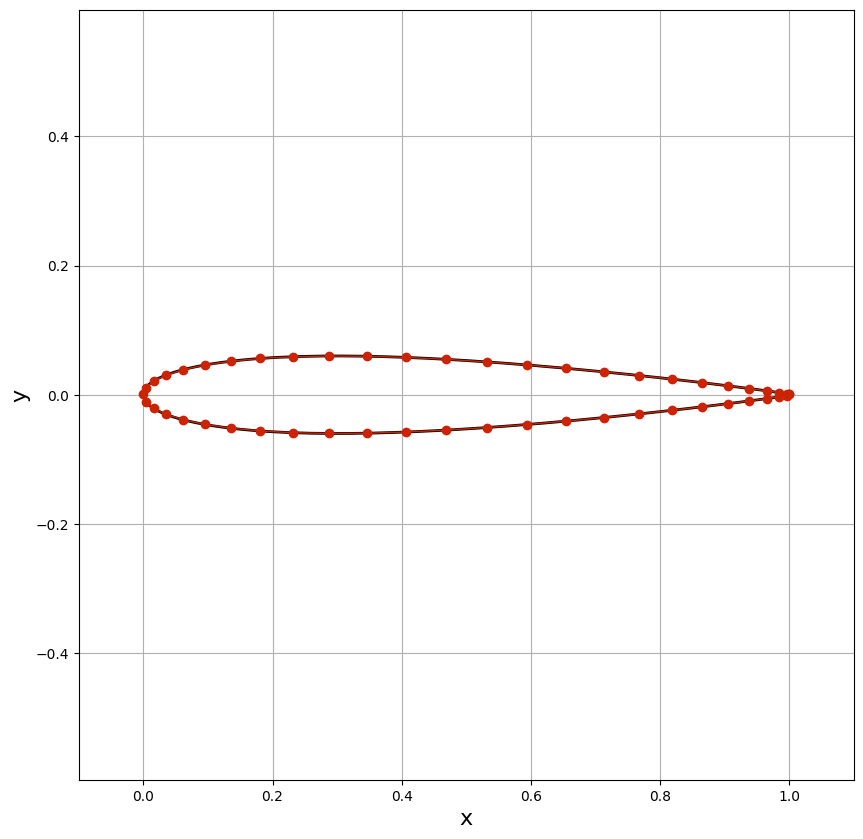

FileNotFoundError: Data/naca0012/naca0012_surfCP_Re6.44e+05a0.0.dat not found.

In [14]:
def define_panels(x, y, N=40):
    """
    Discretizes the geometry into panels using the 'circle mapping' method.
    
    Parameters
    ----------
    x: 1D array of floats
        x-coordinate of the points defining the geometry.
    y: 1D array of floats
        y-coordinate of the points defining the geometry.
    N: integer, optional
        Number of panels;
        default: 40.
    
    Returns
    -------
    panels: 1D Numpy array of Panel objects
        The discretization of the geometry into panels.
    """
    R = (x.max() - x.min()) / 2                 # Radius of the circle, based on airfoil geometry
    x_center = (x.max() + x.min()) / 2          # X coordinate of center of circle


    x_circle = x_center + R * np.cos(np.linspace(0.0, 2 * math.pi, N + 1))
    # Here we define the x coordinates of the circle
    
    x_ends = np.copy(x_circle)                  # projection of the x-coord on the surface
    y_ends = np.empty_like(x_ends)              # initialization of the y-coord Numpy array

    x, y = np.append(x, x[0]), np.append(y, y[0])  # extend arrays using numpy.append
    
    # computes the y-coordinate of end-points
    I = 0
    for i in range(N):
        while I < len(x) - 1:
            if (x[I] <= x_ends[i] <= x[I + 1]) or (x[I + 1] <= x_ends[i] <= x[I]):
                break
            else:
                I += 1
        a = (y[I + 1] - y[I]) / (x[I + 1] - x[I])
        b = y[I + 1] - a * x[I + 1]
        y_ends[i] = a * x_ends[i] + b
        print(i)
        print(I)
    y_ends[N] = y_ends[0]
    
    panels = np.empty(N, dtype=object)
    for i in range(N):
        panels[i] = Panel(x_ends[i], y_ends[i], x_ends[i + 1], y_ends[i + 1])
    
    return panels


# Testing source panel method using a symmetric airfoil at zero angle of attack
naca = True
alf = 0
foil = '0012'
kinvisc = 15.52 * (10**-6)
Re = (10*1)/(kinvisc)
Re = 0
pyxfoil.GetPolar(foil, naca, alf, Re)

filename = 'Data/naca0012/naca0012.dat'
x, y = np.loadtxt(filename, dtype=float, unpack=True, skiprows = 1)

N = 50
panels = define_panels(x,y,N)




# plot the geometry and the panels
width = 10
plt.figure(figsize=(width, width))
plt.grid()
plt.xlabel('x', fontsize=16)
plt.ylabel('y', fontsize=16)
plt.plot(x, y, color='k', linestyle='-', linewidth=2)
plt.plot(np.append([panel.xa for panel in panels], panels[0].xa),
            np.append([panel.ya for panel in panels], panels[0].ya),
            linestyle='-', linewidth=1, marker='o', markersize=6, color='#CD2305')
plt.axis('equal')
plt.xlim(-0.1, 1.1)
plt.ylim(-0.1, 0.1)
plt.show()

# Analysis using xfoil 
filename = 'Data/naca0012/naca0012_surfCP_Re6.44e+05a0.0.dat'
x12,y12,Cp12 = np.loadtxt(filename, unpack = True, skiprows = 3)

U_infty = 10
analyze_panels(panels, U_infty)

plt.figure(figsize=(10, 6))
plt.grid()
plt.xlabel('x', fontsize=16)
plt.ylabel('$C_p$', fontsize=16)
plt.plot(x12, Cp12)
plt.gca().invert_yaxis()

plt.plot([p.xc for p in panels], [p.cp for p in panels],
               label='source-panel method',
               color='#CD2305')

plt.title('Xfoil vs Source Panel', fontsize=16)
plt.legend(loc='best', prop={'size':16})
plt.show()



0
0
1
0
2
1
3
3
4
5
5
7
6
9
7
12
8
14
9
18
10
21
11
24
12
28
13
31
14
35
15
39
16
42
17
46
18
49
19
52
20
55
21
59
22
63
23
68
24
74
25
80
26
87
27
92
28
98
29
102
30
106
31
109
32
112
33
115
34
118
35
121
36
124
37
128
38
131
39
135
40
138
41
141
42
144
43
147
44
149
45
152
46
154
47
155
48
157
49
158


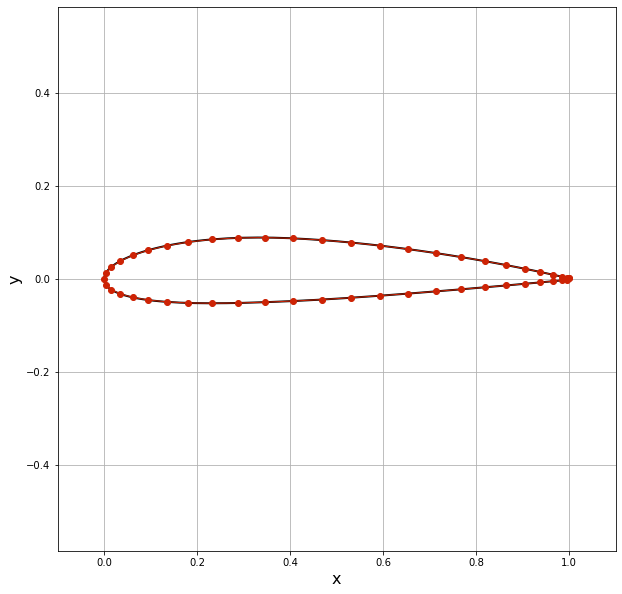

Panel Analysis Complete!


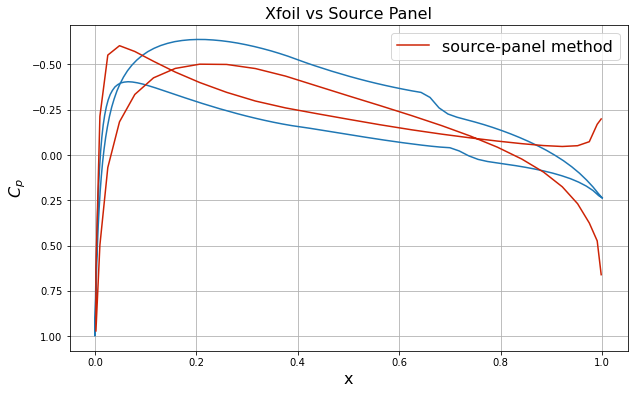

In [134]:
### Some testing, delete later

# Testing source panel method using a cambered airfoil at zero angle of attack
naca = True
alf = 0
foil = '2414'
kinvisc = 15.52 * (10**-6)
Re = (10*1)/(kinvisc)
Re = 0 
pyxfoil.GetPolar(foil, naca, alf, Re)

filename = 'Data/naca2414/naca2414.dat'
x, y = np.loadtxt(filename, dtype=float, unpack=True, skiprows = 1)

N = 50
panels = define_panels(x,y,N)

# plot the geometry and the panels
width = 10
plt.figure(figsize=(width, width))
plt.grid()
plt.xlabel('x', fontsize=16)
plt.ylabel('y', fontsize=16)
plt.plot(x, y, color='k', linestyle='-', linewidth=2)
plt.plot(np.append([panel.xa for panel in panels], panels[0].xa),
            np.append([panel.ya for panel in panels], panels[0].ya),
            linestyle='-', linewidth=1, marker='o', markersize=6, color='#CD2305')
plt.axis('equal')
plt.xlim(-0.1, 1.1)
plt.ylim(-0.1, 0.1)
plt.show()
# Creating panels works well

# Analysis using xfoil 
filename = 'Data/naca2414/naca2414_surfCP_Re6.44e+05a0.0.dat'
x14,y14,Cp14 = np.loadtxt(filename, unpack = True, skiprows = 3)

U_infty = 10
analyze_panels(panels, U_infty)

plt.figure(figsize=(10, 6))
plt.grid()
plt.xlabel('x', fontsize=16)
plt.ylabel('$C_p$', fontsize=16)
plt.plot(x14, Cp14)
plt.gca().invert_yaxis()

plt.plot([p.xc for p in panels], [p.cp for p in panels],
               label='source-panel method',
               color='#CD2305')

plt.title('Xfoil vs Source Panel', fontsize=16)
plt.legend(loc='best', prop={'size':16})
plt.show()
